# This project consists of data wrangling  the weRateDogs twitter account.  Three different datasets will be used
## Table of Contents
<ul>
<li><a href="#gather">Gather</a></li>
<li><a href="#assess">Assess</a></li>
<li><a href="#clean">Clean</a></li>
<li><a href="#visual">Analysis/Visualization</a></li>
</ul>

<a id='gather'></a>
# GATHER
## Three datasets will need to be assessed and cleaned in order to perform analysis.

* twitter_archive - contains tweets form weratedogs*
* Image_predictions - contains the jpgs. of predictions for the type of breed*
* Additional data from weratedogs that were forgotten in the twitter_archive*  


**Created a function to get dog predictions using the url provided and writing to image_prdections.tsv**


In [299]:
# import dependencies
import pandas as pd
#wrapper for twitter
import tweepy
#import jason for handling the api data
import json
#seaborn
import seaborn as sns
#matplotlib
import matplotlib.pyplot as plt

**check_files checks if the dog predictions and twitter file has been created. The key parameter is used to determine 
if the check is for the dog file or twitter file. I am doing this so when I re-run the code these files 
won't be re-produced again if they exist and to avoid the long time on the twitter data**

In [300]:
def check_files(file,key):
    #import pathlib to test for existence of file. 
    import pathlib
    #pass the file parameter to pathlib to see if file exists
    path = pathlib.Path(file)
    #check if dog or twitter
    if (key =='dog'):
        
        #if file doesn't exist create it
        if (path.exists() == False ):
            
            get_dog_predictions()
            
        
    else:
        #check if twitter file exists
        if (path.exists() == False):
            #get twitter api first then data
           
            get_twitter_api()
            get_twitter_data()
        



**Calls check_files to see if the image_predictions and tweet_json files have been created.  create the dog_images
dataframe.  The tweet_json dataframe is created further down as there is more logic to perform**

In [301]:
#check if image file exists.
check_files('image_predictions.tsv','dog')
#create the images frame
df_dog_images = pd.read_csv('image_predictions.tsv', sep='\t')

#check if tweete file exists
check_files('tweet_json.txt','tweet')

**This function downloads the url for the dog image predictions and writes to a file called
image_predictions.tsv**

In [302]:
def get_dog_predictions():
    import requests

    # download the image-predictions.tsv file for predicting breeds of dogs based on images
    download_url= "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
    target_tsv_path = "image_predictions.tsv"

    response = requests.get(download_url)
    
    #check that request was successful
    response.raise_for_status()    

    #write to target file - tweet_json.txt
    with open(target_tsv_path, "wb") as f:
        f.write(response.content)
        
    #print download ready if successful
    print("Download ready.")



**read the twitter-archive-enhanced into a dataframe**

In [303]:
#read twitter archive into datframe
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')



**get_twitter_api is performed once only.  It is used to get the api and twitter data.  Once I have the twitter data this 
routine does not need to be run again**

In [304]:
def get_twitter_api():
    #API key
    consumer_key=""

    #API secret key
    consumer_secret=""

    #access token
    access_token="" 

    #access token secret
    access_secret=""

    #setup authorization
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    #instantiate object
    api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

    #check if succesful
    api.update_status('tweepy + oauth!')

    print('api instantiate successful')

**Had to run get_twitter_api again as I forgot to use wait_on_rate_limit and this caused problems.
needed to get rid of the status.id so I can run with a clean slate.  found this great function on stack overflow**

In [305]:
def destroy_status():
    for status in tweepy.Cursor(api.user_timeline).items():
        try:
            api.destroy_status(status.id)
        except:
            pass

**Along with the get_twitter_api ,  this routine get_twitter_data only needs to be run once as I am writing all content to
a file to be used to create a dataframe**

In [306]:
def get_twitter_data():
    
    
    #for each twitter id make an api call to twitter to receive data for the specific id
    with open('tweet_json.txt', 'w') as json_file:
        for id in df_twitter_archive['tweet_id']:
            try:
                print('tweet_id is:', id)
                tweet_data = api.get_status(id, tweet_mode='extended')
                json.dump(tweet_data._json,json_file)
                json_file.write('\n')
            #we catch an exception and continue as the error is an id not found
            except tweepy.TweepError as e:
                print('exception, error is:',e.response.text)
                continue
#display successfully created when loop has finished    
print('tweetfile successfully created')
            

tweetfile successfully created


**Read the tweet_json.txt file line by line since there are mulitple json records.**

In [307]:
#read json file line by line and store in data
with open('tweet_json.txt') as f:
    data = [json.loads(line) for line in f]  



**create a list of dictionaries from json file.    fields of interest are id to match tweet_id from other dataframes, favorite_count and retweet_count.  this will be used to create a dataframe**

In [308]:
#array to hold dictionary of field from file
df_tweet_extras=[]
data_length = len(data)
#for loop to loop thru all data and extract id, favorite_count and retweet_count
for i in range(data_length):
    tweet_id = data[i]['id']
    favorite_count = data[i]['favorite_count']
    retweet_count = data[i]['retweet_count']
    #append to df_tweet_extras
    df_tweet_extras.append({'tweet_id': int(tweet_id),
                           'favorite_count': int(favorite_count),
                           'retweet_count': int(retweet_count)})



   **Create a dataframe with the df_tweet_extras created above** 

In [309]:
df_tweet = pd.DataFrame(df_tweet_extras,columns=['tweet_id','favorite_count','retweet_count'])
#verify df created
df_tweet.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36303,7726
1,892177421306343426,31296,5718
2,891815181378084864,23568,3787
3,891689557279858688,39584,7881
4,891327558926688256,37795,8506


<a id='assess'></a>
# ASSESS the following dataframes created from the gather phase.
## df_twitter_archive, df_tweet, df_dog_images

## 1. assess the df_twitter_archive dataframe

In [310]:
#visual inspection 
df_twitter_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [311]:
#stats counts
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [312]:
denom_ten=df_twitter_archive.query('rating_denominator != 10').count()
print(f'There are {denom_ten[12]} denominators not equal to 10')

There are 23 denominators not equal to 10


In [313]:
#check for duplicates
df_twitter_archive.duplicated().sum()

0

In [314]:
#look at data types
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [315]:
#check for rating_numerators greater than 15.  weRateDogs is know for giving 12/10 for example
df_twitter_archive.query('rating_numerator > 15').count()[0]

26

In [316]:
#null values
df_twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [317]:
#dimensions of frame
df_twitter_archive.shape

(2356, 17)

In [318]:
#check if any rows have NO stages identified
df_twitter_archive.query('doggo == "None" & floofer == "None" & pupper == "None" & puppo == "None" ').count()['doggo']

1976

In [319]:
#check for all the different names
df_twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Ricky        1
Shiloh       1
Ronduh       1
Anna         1
Millie       1
Name: name, Length: 957, dtype: int64

## 2. Assess df_tweet

In [320]:
#visualize
df_tweet.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36303,7726
1,892177421306343426,31296,5718
2,891815181378084864,23568,3787
3,891689557279858688,39584,7881
4,891327558926688256,37795,8506


In [321]:
#stats counts
df_tweet.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7580.116688,2712.114972
std,6.823170e+16,11762.399595,4586.791500
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1322.000000,548.500000
50%,7.182469e+17,3300.000000,1273.000000
75%,7.986692e+17,9285.000000,3150.500000
max,8.924206e+17,156654.000000,78085.000000


In [322]:
#does any id have a retweet_count of 0
df_tweet.query('retweet_count == 0').count()

tweet_id          0
favorite_count    0
retweet_count     0
dtype: int64

In [323]:
#does any id have a favorite count of 0
df_tweet.query('favorite_count == 0').count()

tweet_id          163
favorite_count    163
retweet_count     163
dtype: int64

In [324]:
#data types
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [325]:
df_tweet.duplicated().sum()

0

In [326]:
df_tweet.isnull().sum()

tweet_id          0
favorite_count    0
retweet_count     0
dtype: int64

In [327]:
df_tweet.shape

(2331, 3)

# 3. Assess df_dog_images

In [328]:
#dimensions
df_dog_images.shape

(2075, 12)

In [329]:
#check stats
df_dog_images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [330]:
#data types
df_dog_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [331]:
#check duplicates
df_dog_images.duplicated().sum()

0

In [332]:
#check for null values
df_dog_images.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [333]:
#look at most predictions that are True
df_dog_images['p1_dog'].sum(),df_dog_images['p2_dog'].sum(),df_dog_images['p3_dog'].sum()

(1532, 1553, 1499)

In [334]:
#visual
df_dog_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


 **Quality Issues for df_twitter_archive**
1. denominator needs to be 10 for all rows
2. timestamp should be a date/timestamp format and not string
3. 10 columns will be useful(tweet_id,timestamp,text, rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo)
4. Some dog names have None  and some name have just the letter 'a look for actual dog names if any
5. letter 'a'  for dogs that did not have a name should be None for consistency 
6. now use not_provided for name instead of None
7. rating_numerator should not be higher than 15

**Quality issues for df_twitter**
1. column names favorite_count and retweet_count should be likes and retweets for simplicity
2. number of rows different for all frames.  (This will be handled in the merge)

**Quality issues for df_dog_images**
1. some columns are useful - tweet_id, jpg_url,p2, p2_dog.  p2_dog has most true predictions.
2. jpg_url, p2, and p2_dog column names should be changed

**Tidy issues**
1. df_twitter_archive - create one dog stage columns with appropriate stages.  If more than one exists use the word "multiple"
2. merge all three dataframes into one master frame

<a id='clean'></a>
# Clean the quality and tidy issues 

**make copies of all 3 frames to work on**

In [335]:
#make copies
df_dog_images_copy = df_dog_images.copy()
df_twitter_archive_copy = df_twitter_archive.copy()
df_tweet_copy = df_tweet.copy()

# Twitter archive copy

**Define - Include only rows that has a 10 for rating_denominator** 

**code**

In [336]:
df_twitter_archive_copy= df_twitter_archive_copy.query('rating_denominator == 10')


**test**

In [337]:
df_twitter_archive_copy.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


**Define - change timestamp to date/timestamp format**

**code**

In [338]:
df_twitter_archive_copy.timestamp = pd.to_datetime(df_twitter_archive_copy.timestamp)

**test**

In [339]:
df_twitter_archive_copy.timestamp.dtype

datetime64[ns, UTC]

**Define - 10 columns seem useful. only keep twitter_id, timestamp,text,rating_numerator,rating_denominator,name,
doggo,floofer,pupper,puppo**

**code**

In [340]:
#assign columns to keep
df_twitter_archive_copy = df_twitter_archive_copy[['tweet_id','timestamp','text','rating_numerator','rating_denominator',
                                                  'name','doggo','floofer','pupper','puppo']]

**test**

In [341]:
df_twitter_archive_copy.head(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,None,None,None


**Define - remove all rating_numerators that are higher than 15**

**code**

In [342]:
#rows before removal
df_twitter_archive_copy.shape

(2333, 10)

In [343]:
#rows after removal
df_twitter_archive_copy = df_twitter_archive_copy.query('rating_numerator < 16')
df_twitter_archive_copy.shape

(2323, 10)

**check to see if any decimal  points such as 10.5 in text for rating_numerator.  If yes, update value in frame**

In [344]:
#widen column width to see the whole text
pd.set_option('display.max_colwidth',250)
#check for decimals using a reg expression
df_twitter_archive_copy[df_twitter_archive_copy.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5


**two rows have decimal points in the rating_numerator.  Update each row by index with correct value. Note: I will be leaving the dtype as float for the numerator for numeric operations if necessary**



In [345]:
#update rating_numerator based on above.  index 45 should be 13.5 and index 1689 should be 9.5
df_twitter_archive_copy.loc[45,'rating_numerator']=13.5
df_twitter_archive_copy.loc[1689,'rating_numerator']=9.5

In [346]:
#verify bella at index 45
df_twitter_archive_copy.query('name == "Bella"').head(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19+00:00,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10,Bella,None,None,None,None
60,880465832366813184,2017-06-29 16:39:47+00:00,This is Bella. She had her first beach experience this morning. Complete success. 12/10 would perform a sandy boop https://t.co/4VsFysDmiw,12.0,10,Bella,None,None,None,None
1089,737800304142471168,2016-06-01 00:17:54+00:00,This is Bella. She's ubering home after a few too many drinks. 10/10 socially conscious af https://t.co/KxkOgq80Xj,10.0,10,Bella,None,None,None,None


**Define - remove dog names with None and letter 'a' and replace with actual dog name if available**

**code**

In [347]:
#create a subset of rows that have the word "named" in them
df = df_twitter_archive_copy.query('text.str.contains("named")',engine='python')

In [348]:
#get the index associated with the row fo updating purposes
name_index = df.text.str.split().index

name_index

Int64Index([ 603, 1853, 1955, 2034, 2066, 2116, 2125, 2128, 2146, 2161, 2166,
            2191, 2204, 2218, 2227, 2235, 2249, 2255, 2264, 2269, 2273, 2304,
            2311, 2314],
           dtype='int64')

In [349]:
#split the text and create a list
name_list = df.text.str.split().to_list()

In [350]:
#loop thru the lists to get the index for update and the name to be updated.
#the outerloop control the number of indexes and names
#the inner loop controls just the index and the name.
#This will create a tuple of id's and names for update of frame

df_list=[]
for i  in range(len(name_list)):
    for j in range(len(name_list[i])):
        #check if 'named' is in the list
        if (name_list[i][j]) == 'named':
            #on a match append the list with a tuple consisting of the id and name. increase the index
            #by 1 to get the name which is one element after the 'named' index.
            df_list.append(( name_index[i],
                             name_list[i][j + 1]))
            #break out of inner loop and continue with outerloop
            break
#display the cominations of id and names to be updated.
print('names are',df_list)
    

names are [(603, 'Tickles.'), (1853, 'Wylie.'), (1955, 'Kip.'), (2034, 'Jacob'), (2066, 'Rufus.'), (2116, 'Spork.'), (2125, 'Cherokee.'), (2128, 'Hemry.'), (2146, 'Alphred.'), (2161, 'Alfredo.'), (2166, 'Zeus.'), (2191, 'Leroi.'), (2204, 'Berta.'), (2218, 'Chuk.'), (2227, 'Guss.'), (2235, 'Alfonso.'), (2249, 'Cheryl.'), (2255, 'Jessiga.'), (2264, 'Klint.'), (2269, 'Tickles.'), (2273, 'Kohl.'), (2304, 'Pepe.'), (2311, 'Octaviath.'), (2314, 'Johm.')]


In [351]:
#loop thru the tuple list with outerloop being the number of id's and names(24)
#loop thru inner loop with just id and name.  increase index by 1 to get the dog name which is after the id.
for i in range(len(df_list)):
    for j in range(len(df_list[i])):
        #get id and dog name
        id = df_list[i][j]
        dog_name = df_list[i][j + 1]     
        #update dog name based on id for test
        df.at[id,'name']=dog_name
        #updated main copy after test worked
              
        df_twitter_archive_copy.at[id,'name']=dog_name
        #break out of inner loop and get next tuple
        break
               

**Test with a subset**

In [352]:
df

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
603,798628517273620480,2016-11-15 20:47:30+00:00,RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,12.0,10,Tickles.,None,None,None,None
1853,675706639471788032,2015-12-12 15:59:51+00:00,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,10.0,10,Wylie.,None,None,None,None
1955,673636718965334016,2015-12-06 22:54:44+00:00,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,10.0,10,Kip.,None,None,None,None
2034,671743150407421952,2015-12-01 17:30:22+00:00,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,11.0,10,Jacob,None,None,None,None
2066,671147085991960577,2015-11-30 02:01:49+00:00,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,9.0,10,Rufus.,None,None,None,None
2116,670427002554466305,2015-11-28 02:20:27+00:00,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,9.0,10,Spork.,None,None,None,None
2125,670361874861563904,2015-11-27 22:01:40+00:00,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,9.0,10,Cherokee.,None,None,None,None
2128,670303360680108032,2015-11-27 18:09:09+00:00,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,9.0,10,Hemry.,None,None,None,None
2146,669923323644657664,2015-11-26 16:59:01+00:00,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,10.0,10,Alphred.,None,None,None,None
2161,669564461267722241,2015-11-25 17:13:02+00:00,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,10.0,10,Alfredo.,None,None,None,None


**Define - Replace all  just letter 'a' in name columns with 'None'  that didn't have a dog name in text**

**code**

In [353]:
#replace the letter 'a'  in name columns with None
df_twitter_archive_copy.name.replace({'a': 'None'},inplace=True)

**test**

In [354]:
#query name to see if letter a exists
df_twitter_archive_copy.query('name == "a"')

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


**Define- Replace None with not_provided**

**code**

In [355]:
df_twitter_archive_copy.name.replace({'None': 'not_provided'},inplace=True)

**test**

In [356]:
df_twitter_archive_copy.query('name == "None" ')

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


# df_tweet copy

**Define -replace favorite_count with likes and retweet_count with retweets**

**code**

In [357]:
df_tweet_copy.rename(columns={'favorite_count': 'likes', 'retweet_count': 'retweets'},inplace=True)

**test**

In [358]:
df_tweet_copy.head(1)

,tweet_id,likes,retweets
0,892420643555336193,36303,7726


# df_dog_images copy

**Define - keep only tweet_id, jpg_url, p2, p2_dog since p2 had most true prediction**

In [359]:
df_dog_images_copy.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [360]:
df_dog_images_copy = df_dog_images[['tweet_id', 'jpg_url', 'p2', 'p2_dog']]

**test**

In [361]:
df_dog_images_copy.head(1)

,tweet_id,jpg_url,p2,p2_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,collie,True


**Define - replace column names.  jpg_url with dog_pic_url, p2 with prediction  p2_dog with match**

In [362]:
df_dog_images_copy.rename(columns={'jpg_url':'dog_pic_url', 'p2': 'prediction','p2_dog': 'match'},inplace=True)

**test**

In [363]:
df_dog_images_copy.head(1)

,tweet_id,dog_pic_url,prediction,match
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,collie,True


# Tidy
**Merge all three data frames on tweet_id using a inner join.  If the key from twitter_archive doesn't match a record from 
all other frames those records will not be merged.**

In [364]:
#merge all three frames using right join to get only all rows that have matching tweet_ids in all three frames
#chain the merges with dog_images last. 
df_twitter_merged = df_twitter_archive_copy.merge(df_tweet_copy, on='tweet_id',how='inner').merge(df_dog_images_copy,
                                                                                                  on='tweet_id',how='inner')

**test**

In [365]:
df_twitter_merged.shape

(2036, 15)

In [366]:
df_twitter_merged.isnull().sum()

tweet_id              0
timestamp             0
text                  0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
likes                 0
retweets              0
dog_pic_url           0
prediction            0
match                 0
dtype: int64

In [367]:
#all columns have merged correctly
df_twitter_merged.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,likes,retweets,dog_pic_url,prediction,match
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10,Phineas,None,None,None,None,36303,7726,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,bagel,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10,Tilly,None,None,None,None,31296,5718,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Pekinese,True
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10,Archie,None,None,None,None,23568,3787,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,malamute,True
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10,Darla,None,None,None,None,39584,7881,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,True
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10,Franklin,None,None,None,None,37795,8506,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,English_springer,True


In [368]:
df_twitter_merged.tail(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,likes,retweets,dog_pic_url,prediction,match
2034,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,7.0,10,not_provided,None,None,None,None,121,42,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,miniature_pinscher,True
2035,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,8.0,10,not_provided,None,None,None,None,2419,463,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,collie,True


**Define - create a new column called "stage" and populate with current stage.  If more than one use "mulitple"**

**code**

In [369]:

#replace None with spaces-  "None is just in the stages(Doggo, floofer, pupper and puppo)"
df_twitter_merged.replace({'None':''},inplace=True)
#concatenate all stages and add store in a new column
df_twitter_merged['stage'] = df_twitter_merged.doggo + df_twitter_merged.floofer + df_twitter_merged.pupper + \
                            df_twitter_merged.puppo


In [370]:
#check if stage has multiple stages (ex. doggopupper) 
df_twitter_merged['stage']=df_twitter_merged['stage'].mask(df_twitter_merged.stage.str.len() > 8, 'multiple')

In [371]:
##### put stages next to name
col_idx=[0,1,2,3,4,5,15,6,7,8,9,10,11,12,13,14]
df_twitter_merged = df_twitter_merged[[df_twitter_merged.columns[i] for i in col_idx]]

In [372]:
#drop  doggo, floofer, pupper and puppo columns
df_twitter_merged.drop(['doggo','floofer','pupper','puppo'],axis=1,inplace=True)

In [373]:
#replace spaces in stage columns with 'not_provided'
df_twitter_merged.stage.replace({'':'not_provided'},inplace=True)

**test**

In [374]:
#verify stage is now after name and doggo, floofer, pupper and puppo have been dropped form frame
df_twitter_merged.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'stage', 'likes', 'retweets',
       'dog_pic_url', 'prediction', 'match'],
      dtype='object')

In [375]:
#veirfy stage is populated correctly
df_twitter_merged.query('stage != "not_provided"').sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,likes,retweets,dog_pic_url,prediction,match
263,832032802820481025,2017-02-16 01:04:13+00:00,This is Miguel. He was the only remaining doggo at the adoption center after the weekend. Let's change that. 12/10\n\nhttps://t.co/P0bO8mCQwN https://t.co/SU4K34NT4M,12.0,10,Miguel,doggo,18011,4700,https://pbs.twimg.com/media/C4v5a4UWcAIRygc.jpg,Ibizan_hound,True
832,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,10,not_provided,doggo,156654,78085,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,ice_bear,False
1329,685547936038666240,2016-01-08 19:45:39+00:00,Everybody needs to read this. Jack is our first 14/10. Truly heroic pupper https://t.co/3m6bNGXWnM,14.0,10,not_provided,pupper,32928,15624,https://pbs.twimg.com/media/CYOONfZW8AA7IOA.jpg,oscilloscope,False
270,831315979191906304,2017-02-14 01:35:49+00:00,I couldn't make it to the #WKCDogShow BUT I have people there on the ground relaying me the finest pupper pics possible. 13/10 for all https://t.co/jd6lYhfdH4,13.0,10,not_provided,pupper,6601,1133,https://pbs.twimg.com/media/C4lst0bXAAE6MP8.jpg,soft-coated_wheaten_terrier,True
1042,708845821941387268,2016-03-13 02:43:08+00:00,Here's a pupper with magic eyes. Not wearing a seat belt tho (irresponsible af). Very distracting to driver. 9/10 https://t.co/5DLJB4ssvI,9.0,10,not_provided,pupper,2978,897,https://pbs.twimg.com/media/CdZTgynWwAATZcx.jpg,kelpie,True
360,817181837579653120,2017-01-06 01:31:47+00:00,RT @dog_rates: Here's a pupper with squeaky hiccups. Please enjoy. 13/10 https://t.co/MiMKtsLN6k,13.0,10,not_provided,pupper,0,8641,https://pbs.twimg.com/ext_tw_video_thumb/815965888126062592/pu/img/JleSw4wRhgKDWQj5.jpg,Tibetan_terrier,True
1141,700143752053182464,2016-02-18 02:24:13+00:00,When it's Janet from accounting's birthday but you can't eat the cake cuz it's chocolate. 10/10 hang in there pupper https://t.co/Fbdr5orUrJ,10.0,10,not_provided,pupper,7525,2714,https://pbs.twimg.com/media/CbdpBmLUYAY9SgQ.jpg,crossword_puzzle,False
1113,703268521220972544,2016-02-26 17:20:56+00:00,Happy Friday here's a sleepy pupper 12/10 https://t.co/eBcqv9SPkY,12.0,10,not_provided,pupper,1971,548,https://pbs.twimg.com/media/CcKC-5LW4AAK-nb.jpg,fur_coat,False
459,800018252395122689,2016-11-19 16:49:49+00:00,Here's a doggo doin a struggle. 11/10 much determined https://t.co/gQqRBfkX4I,11.0,10,not_provided,doggo,29036,13522,https://pbs.twimg.com/ext_tw_video_thumb/800018199223959552/pu/img/3Qp73edtkZO-qWPy.jpg,punching_bag,False
1672,672898206762672129,2015-12-04 22:00:08+00:00,This is Cheryl AKA Queen Pupper of the Skies. Experienced fighter pilot. Much skill. True hero. 11/10 https://t.co/i4XJEWwdsp,11.0,10,Cheryl,pupper,880,408,https://pbs.twimg.com/media/CVadWcCXIAAL4Sh.jpg,bobsled,False


In [376]:
#verify not_provided is populated for dogs that don't have a stage
df_twitter_merged.query('stage == "not_provided"').head(2)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,likes,retweets,dog_pic_url,prediction,match
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10,Phineas,not_provided,36303,7726,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,bagel,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10,Tilly,not_provided,31296,5718,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Pekinese,True


**write to a csv file**

In [389]:
#write to file and drop index
df_twitter_merged.to_csv("twitter-archive-master.csv",index=False)

<a id='visual'></a>
# Analysis and Visualization
## Questions
**1. what are the most likes and retweets for each stage**
<br>
**2. who has the most retweets as this is the indicator for best tweet**
<br>
**3. what are the common names**
<br>
**4. what stages are in the top 5 for most tweets**




**group by stages and get the top likes and retweets for each stage**

In [378]:
#group by stages getting max likes and retweets
df_group_stage =df_twitter_merged.groupby('stage')['likes','retweets'].max().reset_index()

In [379]:
#verify
df_group_stage

,stage,likes,retweets
0,doggo,156654,78085
1,floofer,30394,16151
2,multiple,50082,17388
3,not_provided,120985,56926
4,pupper,116691,33056
5,puppo,133398,43986


**remove  multiple and not_provided as to be included must have actual stage name**

In [380]:
#remove multiple and not provided using the indexes
df_group_stage.drop([2,3],inplace=True)

In [381]:
#sort likes in descending order
df_group_stage.sort_values('likes',ascending=False,inplace=True)

In [382]:
#verify
df_group_stage

,stage,likes,retweets
0,doggo,156654,78085
5,puppo,133398,43986
4,pupper,116691,33056
1,floofer,30394,16151


**transform frame with melt to make a long columns with likes/retweets and each corresponding count to be used 
in creating a barplot  for comparisons**

In [383]:
#melt likes and retweets
df_melt = pd.melt(df_group_stage,id_vars=['stage'],var_name="type",value_name="counts")

In [384]:
#verify
df_melt

,stage,type,counts
0,doggo,likes,156654
1,puppo,likes,133398
2,pupper,likes,116691
3,floofer,likes,30394
4,doggo,retweets,78085
5,puppo,retweets,43986
6,pupper,retweets,33056
7,floofer,retweets,16151


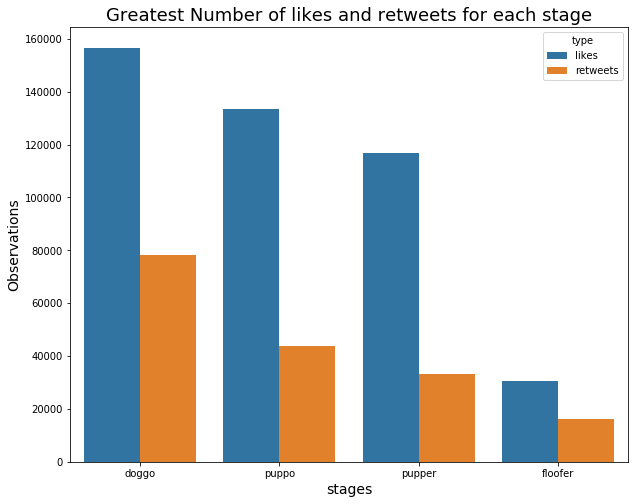

In [385]:
#create a grouped bar chart
plt.figure(figsize=(10, 8))
#using seaborn
sns.barplot(x="stage", y="counts",data=df_melt,hue='type', ci=None )
#x and y labels
plt.ylabel("Observations", size=14)
plt.xlabel("stages", size=14)
#title label
plt.title("Greatest Number of likes and retweets for each stage", size=18)
#display the bar
plt.show()


**It is clear that stage doggo has most likes and retweets and floofers don't do too well
makes sense that likes outnumber retweets.  Easy to just press a button for like, but if you retweet it goes on your
page.  So not as many, but a retweet has more weight if someone really likes your tweet.  so Doggo is the 
number 1 stage that people like the most**

**find tweet with most retweets**

In [386]:
#get max retweet first
max_retweets = df_twitter_merged.retweets.max()
#use max_retweets to find the tweet with the largest retweet count
df_max = df_twitter_merged.query('retweets == @max_retweets')
#display
df_max


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,likes,retweets,dog_pic_url,prediction,match
832,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,10,not_provided,doggo,156654,78085,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,ice_bear,False


**top 5 names are charlie, oliver, tucker, penny and cooper**

In [387]:
#display the names a
df_twitter_merged.name.value_counts().head(10)

not_provided    590
Penny            10
Cooper           10
Tucker           10
Oliver           10
Charlie          10
Lucy              9
Bo                8
Sadie             8
Winston           8
Name: name, dtype: int64

**top 5 stages with most likes and retweets**

In [388]:
#sort likes in descending order
df_twitter_merged.nlargest(5,['likes','retweets'])

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,likes,retweets,dog_pic_url,prediction,match
832,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,10,not_provided,doggo,156654,78085,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,ice_bear,False
320,822872901745569793,2017-01-21 18:26:02+00:00,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,10,not_provided,puppo,133398,43986,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Labrador_retriever,True
421,807106840509214720,2016-12-09 06:17:20+00:00,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,10,Stephan,not_provided,120985,56926,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Pomeranian,True
110,866450705531457537,2017-05-22 00:28:40+00:00,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",13.0,10,Jamesy,pupper,116691,33056,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,Boston_bull,True
866,739238157791694849,2016-06-04 23:31:25+00:00,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,10,not_provided,doggo,115659,57876,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,Siberian_husky,True
